In [37]:
import torch
import torch.optim as optim
import numpy as np
import scanpy as sc
import scvelo as scv
from model import NETWORK  # Ensure that model.py is saved in the same directory
from dataloaders import setup_dataloaders  # Ensure that dataloaders.py is saved in the same directory
from utils import manifold_and_neighbors
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path

from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix
import numpy as np
import scvelo as scv
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra


# Setup configuration
latent_dim = 64  # Latent dimension size, can be adjusted
hidden_dim = 512  # Hidden dimension size for the encoder and decoder
batch_size = 12  # Batch size for training
epochs = 100  # Number of epochs for training
learning_rate = 1e-4  # Learning rate for the optimizer
lambda1 = 1e-1  # Weight for heuristic loss
lambda2 = 1 # Weight for discrepancy loss
K = 11  # Number of neighbors for heuristic loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

n_components = 100
n_knn_search = 10
dataset_name = "pancreas"
cell_type_key = "clusters"
model_name = "imVelo"


# Load data
adata = sc.read_h5ad(f"/mnt/data2/home/leonardo/git/imVelo/benchmark/imVelo/{dataset_name}/{model_name}_{dataset_name}.h5ad")

# Use spliced matrix for Isomap embedding
Mu = adata.layers["unspliced"].toarray()
Ms = adata.layers["spliced"].toarray()
Mu_Ms = np.concatenate([Mu,Ms],axis=1)
n_neighbors = 40  # Number of neighbors to consider
# Step 1: Create a nearest-neighbor graph (Euclidean distances for the graph construction)
knn_graph = kneighbors_graph(Mu_Ms, n_neighbors=n_neighbors, mode='distance', include_self=False)

# Step 2: Compute the geodesic distances using Dijkstra's algorithm
# This returns the shortest paths between all pairs of points
geodesic_distances = dijkstra(csgraph=knn_graph, directed=False, return_predecessors=False)

# Step 3: Build the neighbor matrix
# For each cell, find its nearest neighbors based on geodesic distances
nearest_neighbors = []
for i in range(geodesic_distances.shape[0]):
    sorted_indices = np.argsort(geodesic_distances[i])
    nearest_neighbors.append(sorted_indices[:n_neighbors + 1])  # Include the cell itself

nearest_neighbors_matrix = np.array(nearest_neighbors)


adata.uns["indices"] = nearest_neighbors_matrix

# Compute moments using the custom neighbor graph
#scv.pp.moments(adata, n_neighbors=200, use_rep="isomap")

input_dim = adata.shape[1] * 2  # Assuming 2000 unspliced and 2000 spliced genes as input

# Initialize model, optimizer, and loss function
model = NETWORK(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up data loaders
train_loader, test_loader, full_data_loader = setup_dataloaders(adata, batch_size=batch_size, train_size=1, split_data=False)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for batch_idx, (inputs, batch_indices) in enumerate(train_loader):
        inputs = inputs.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        out_dic = model(inputs)
        
        # Compute loss
        losses_dic = model.heuristic_loss(
            adata=adata, 
            x=inputs, 
            batch_indices=batch_indices,
            lambda1=lambda1, 
            lambda2=lambda2, 
            out_dic=out_dic, 
            device=device,
            K=K
        )
        
        # Backward pass and optimization
        loss = losses_dic["total_loss"]
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for monitoring
        running_loss += loss.item()
        
        if batch_idx % 10 == 0:  # Print every 10 batches
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}], Loss: {loss.item()}')
    
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss / len(train_loader)}')

    # Save the model periodically
    """if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')"""

# After training, save final model
torch.save(model.state_dict(), 'final_model.pth')
"""
# Test the model on the test set (if available)
if test_loader is not None:
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():
        for inputs, batch_indices in test_loader:
            inputs = inputs.to(device)
            out_dic = model(inputs)
            
            # Compute test loss
            losses_dic = model.heuristic_loss(
                adata=adata, 
                x=inputs, 
                batch_indices=batch_indices,
                lambda1=lambda1, 
                lambda2=lambda2, 
                out_dic=out_dic, 
                device=device,
                K=K
            )
            total_test_loss += losses_dic["total_loss"].item()

    print(f'Test Loss: {total_test_loss / len(test_loader)}')"""

# Initialize empty layers in adata for storing results
adata.layers["velocity_u"] = np.zeros_like(adata.layers["Mu"])  # Initialize for velocity_u
adata.layers["velocity"] = np.zeros_like(adata.layers["Ms"])  # Initialize for velocity (spliced)
adata.layers["pp"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["nn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["pn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["np"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.obsm["pred"] = np.zeros((adata.shape[0], adata.shape[1] * 2))  # Assuming 2*genes for prediction

# Fetch output dictionary for the entire dataset after training and store results in adata layers
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for inputs, batch_indices in full_data_loader:
        inputs = inputs.to(device)
        out_dic = model(inputs)

        # Store the results in adata layers according to batch_indices
        adata.layers["velocity_u"][batch_indices] = out_dic["v_u"].cpu().numpy()
        adata.layers["velocity"][batch_indices] = out_dic["v_s"].cpu().numpy()
        adata.layers["pp"][batch_indices] = out_dic["pp"].cpu().numpy()
        adata.layers["nn"][batch_indices] = out_dic["nn"].cpu().numpy()
        adata.layers["pn"][batch_indices] = out_dic["pn"].cpu().numpy()
        adata.layers["np"][batch_indices] = out_dic["np"].cpu().numpy()

        # Store predictions in adata.obsm
        adata.obsm["pred"][batch_indices] = out_dic["pred"].cpu().numpy()

print('Results stored in adata.layers and adata.obsm')


Epoch [1/100], Batch [0], Loss: 0.10801661759614944
Epoch [1/100], Batch [10], Loss: 0.07678165286779404
Epoch [1/100], Batch [20], Loss: 0.06538879871368408
Epoch [1/100], Batch [30], Loss: 0.04956582188606262
Epoch [1/100], Batch [40], Loss: 0.043567169457674026
Epoch [1/100], Batch [50], Loss: 0.04918021336197853
Epoch [1/100], Batch [60], Loss: 0.04609976336359978
Epoch [1/100], Batch [70], Loss: 0.03304881602525711
Epoch [1/100], Batch [80], Loss: 0.05994806066155434
Epoch [1/100], Batch [90], Loss: 0.028124993667006493
Epoch [1/100], Batch [100], Loss: 0.04530414938926697
Epoch [1/100], Batch [110], Loss: 0.03812064602971077
Epoch [1/100], Batch [120], Loss: 0.05111274868249893
Epoch [1/100], Batch [130], Loss: 0.031073221936821938
Epoch [1/100], Batch [140], Loss: 0.0494774654507637
Epoch [1/100], Batch [150], Loss: 0.022951187565922737
Epoch [1/100], Batch [160], Loss: 0.028248807415366173
Epoch [1/100], Batch [170], Loss: 0.03051271103322506
Epoch [1/100], Batch [180], Loss: 0

computing velocity graph (using 1/24 cores)


    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


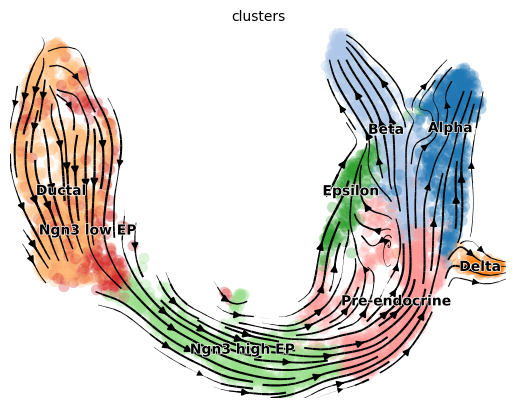

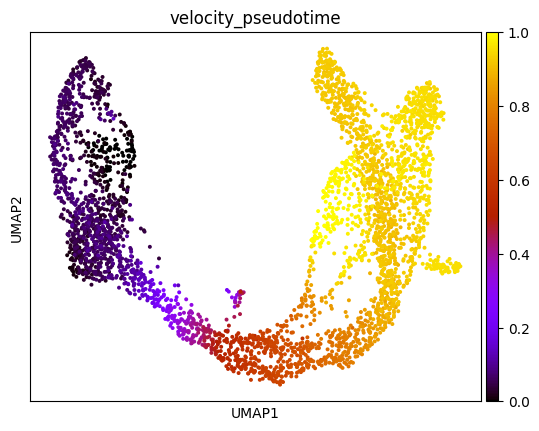

In [38]:
adata.layers["velocity"] *= -1
adata.layers["velocity_u"] *= -1

scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color=cell_type_key)
scv.tl.velocity_pseudotime(adata)
sc.pl.umap(adata, color="velocity_pseudotime", cmap="gnuplot")

In [39]:
import matplotlib.pyplot as plt

def plot_phase_plane(adata, gene_name, dataset, K, u_scale=.01, s_scale=0.01, alpha=0.5, head_width=0.02, head_length=0.03, length_includes_head=False, log=False,
                        norm_velocity=True, filter_cells=False, smooth_expr=True, show_plot=True, save_plot=True, save_path=".",
                        cell_type_key="clusters"):

    if smooth_expr:
        unspliced_expression = adata.layers["Mu"][:, adata.var_names.get_loc(gene_name)].flatten() 
        spliced_expression = adata.layers["Ms"][:, adata.var_names.get_loc(gene_name)].flatten() 
    else:
        unspliced_expression = adata.layers["unspliced"][:, adata.var_names.get_loc(gene_name)].flatten()
        spliced_expression = adata.layers["spliced"][:, adata.var_names.get_loc(gene_name)].flatten()

    # Normalize the expression data
    unspliced_expression_min, unspliced_expression_max = np.min(unspliced_expression), np.max(unspliced_expression)
    spliced_expression_min, spliced_expression_max = np.min(spliced_expression), np.max(spliced_expression)

    # Min-Max normalization
    unspliced_expression = (unspliced_expression - unspliced_expression_min) / (unspliced_expression_max - unspliced_expression_min)
    spliced_expression = (spliced_expression - spliced_expression_min) / (spliced_expression_max - spliced_expression_min)

    # Extract the velocity data
    unspliced_velocity = adata.layers['velocity_u'][:, adata.var_names.get_loc(gene_name)].flatten()
    spliced_velocity = adata.layers['velocity'][:, adata.var_names.get_loc(gene_name)].flatten()

    def custom_scale(data):
        max_abs_value = np.max(np.abs(data))  # Find the maximum absolute value
        scaled_data = data / max_abs_value  # Scale by the maximum absolute value
        return scaled_data

    if norm_velocity:
        unspliced_velocity = custom_scale(unspliced_velocity)
        spliced_velocity = custom_scale(spliced_velocity)


    # Apply any desired transformations (e.g., log) here
    if log:
        # Apply log transformation safely, ensuring no log(0)
        unspliced_velocity = np.log1p(unspliced_velocity)
        spliced_velocity = np.log1p(spliced_velocity)

    # Generate boolean masks for conditions and apply them
    if filter_cells:
        valid_idx = (unspliced_expression > 0) & (spliced_expression > 0)
    else:
        valid_idx = (unspliced_expression >= 0) & (spliced_expression >= 0)

    # Filter data based on valid_idx
    unspliced_expression_filtered = unspliced_expression[valid_idx]
    spliced_expression_filtered = spliced_expression[valid_idx]
    unspliced_velocity_filtered = unspliced_velocity[valid_idx]
    spliced_velocity_filtered = spliced_velocity[valid_idx]

    # Also filter cell type information to match the filtered expressions
    # First, get unique cell types and their corresponding colors
    unique_cell_types = adata.obs[cell_type_key].cat.categories
    celltype_colors = adata.uns[f"{cell_type_key}_colors"]
    
    # Create a mapping of cell type to its color
    celltype_to_color = dict(zip(unique_cell_types, celltype_colors))

    # Filter cell types from the data to get a list of colors for the filtered data points
    cell_types_filtered = adata.obs[cell_type_key][valid_idx]
    colors = cell_types_filtered.map(celltype_to_color).to_numpy()
    plt.figure(figsize=(9, 6.5), dpi=100)
  # Lower dpi here if the file is still too large    scatter = plt.scatter(unspliced_expression_filtered, spliced_expression_filtered, c=colors, alpha=0.6)

    """# Plot velocity vectors
    for i in range(len(unspliced_expression_filtered)):
        cell_type_index = np.where(unique_cell_types == cell_types_filtered[i])[0][0]
        arrow_color = celltype_to_color[cell_types_filtered[i]]  # Use the color corresponding to the cell type
        plt.arrow(
            unspliced_expression_filtered[i], spliced_expression_filtered[i], 
            unspliced_velocity_filtered[i] * u_scale, spliced_velocity_filtered[i] * s_scale, 
            color=arrow_color, alpha=alpha, head_width=head_width, head_length=head_length, length_includes_head=length_includes_head
        )"""

    # Plot velocity vectors
    for i in range(len(unspliced_expression_filtered)):
        cell_type_index = np.where(unique_cell_types == cell_types_filtered[i])[0][0]
        arrow_color = celltype_to_color[cell_types_filtered[i]]  # Use the color corresponding to the cell type
        plt.arrow(
            spliced_expression_filtered[i], unspliced_expression_filtered[i], 
            spliced_velocity_filtered[i] * s_scale, unspliced_velocity_filtered[i] * u_scale, 
            color=arrow_color, alpha=alpha, head_width=head_width, head_length=head_length, length_includes_head=length_includes_head
        )

    plt.ylabel(f'Normalized Unspliced Expression of {gene_name}')
    plt.xlabel(f'Normalized Spliced Expression of {gene_name}')
    plt.title(f'Expression and Velocity of {gene_name} by Cell Type')

    # Create a legend
    patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=celltype_to_color[celltype], markersize=10, label=celltype) 
            for celltype in unique_cell_types]
    plt.legend(handles=patches, title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

    

    if save_plot:
        plt.savefig(save_path, format='png', bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    # Check if show_plot is True, then display the plot
    if show_plot:
        plt.show()
    else:
        plt.close()

    plt.show()


In [40]:
list(adata.var_names)

['Ncoa2',
 'Tram1',
 'Rpl7',
 'Ube2w',
 'Tceb1',
 'Pkhd1',
 'Mcm3',
 'Prim2',
 'Uggt1',
 'Actr1b',
 'Mgat4a',
 'Rev1',
 'Fhl2',
 'Slc39a10',
 'Gls',
 'Mfsd6',
 'Gtf3c3',
 'Pgap1',
 'Sf3b1',
 'Hspd1',
 'Orc2',
 'Ndufs1',
 'Akr1cl',
 'Idh1',
 'Acadl',
 'Erbb4',
 'Fn1',
 'Igfbp5',
 'Tns1',
 'Rnf25',
 'Fev',
 'Cryba2',
 'Cnppd1',
 'Resp18',
 'Epha4',
 'Farsb',
 'Ap1s3',
 'Wdfy1',
 'Serpine2',
 'Cul3',
 'Dner',
 'Trip12',
 'Ngef',
 'Hjurp',
 'Per2',
 'Hdac4',
 'Ndufa10',
 'Dtymk',
 'Rnf152',
 'Pign',
 'Bcl2',
 'Vps4b',
 'Ralb',
 'Epb41l5',
 'Ptpn4',
 'Dbi',
 'Dpp10',
 'Tmem163',
 'Mcm6',
 'Dars',
 'Mapkapk2',
 'Srgap2',
 'Snrpe',
 'Adora1',
 'Timm17a',
 'Nr5a2',
 'Smg7',
 'Lamc1',
 'Dhx9',
 'Npl',
 'Ralgps2',
 'Pappa2',
 'Prdx6',
 'Fmo1',
 'Fmo2',
 'Atp1b1',
 'Mpzl1',
 'Pou2f1',
 'Uck2',
 'Mgst3',
 'Pbx1',
 'Atf6',
 'Sdhc',
 'Ndufs2',
 'Ncstn',
 'Rgs7',
 'Akt3',
 'Adss',
 'Tfb2m',
 'Ahctf1',
 'Psen2',
 'H3f3a',
 'Lbr',
 'Enah',
 'Iars2',
 'Tgfb2',
 'Cenpf',
 'Prox1',
 'Atf3',
 'Ppp2r5a',
 '

In [41]:
adata.var_names

Index(['Ncoa2', 'Tram1', 'Rpl7', 'Ube2w', 'Tceb1', 'Pkhd1', 'Mcm3', 'Prim2',
       'Uggt1', 'Actr1b',
       ...
       'Hsd17b10', 'Smc1a', 'Rps6ka3', 'Eif1ax', 'Map7d2', 'Sh3kbp1', 'Rbbp7',
       'Ctps2', 'Ap1s2', 'Tmem27'],
      dtype='object', length=2933)

In [42]:
adata.var_names

Index(['Ncoa2', 'Tram1', 'Rpl7', 'Ube2w', 'Tceb1', 'Pkhd1', 'Mcm3', 'Prim2',
       'Uggt1', 'Actr1b',
       ...
       'Hsd17b10', 'Smc1a', 'Rps6ka3', 'Eif1ax', 'Map7d2', 'Sh3kbp1', 'Rbbp7',
       'Ctps2', 'Ap1s2', 'Tmem27'],
      dtype='object', length=2933)

In [43]:
#Rpl18a Hba-x Alas2

In [47]:
list(adata.var_names)

['Ncoa2',
 'Tram1',
 'Rpl7',
 'Ube2w',
 'Tceb1',
 'Pkhd1',
 'Mcm3',
 'Prim2',
 'Uggt1',
 'Actr1b',
 'Mgat4a',
 'Rev1',
 'Fhl2',
 'Slc39a10',
 'Gls',
 'Mfsd6',
 'Gtf3c3',
 'Pgap1',
 'Sf3b1',
 'Hspd1',
 'Orc2',
 'Ndufs1',
 'Akr1cl',
 'Idh1',
 'Acadl',
 'Erbb4',
 'Fn1',
 'Igfbp5',
 'Tns1',
 'Rnf25',
 'Fev',
 'Cryba2',
 'Cnppd1',
 'Resp18',
 'Epha4',
 'Farsb',
 'Ap1s3',
 'Wdfy1',
 'Serpine2',
 'Cul3',
 'Dner',
 'Trip12',
 'Ngef',
 'Hjurp',
 'Per2',
 'Hdac4',
 'Ndufa10',
 'Dtymk',
 'Rnf152',
 'Pign',
 'Bcl2',
 'Vps4b',
 'Ralb',
 'Epb41l5',
 'Ptpn4',
 'Dbi',
 'Dpp10',
 'Tmem163',
 'Mcm6',
 'Dars',
 'Mapkapk2',
 'Srgap2',
 'Snrpe',
 'Adora1',
 'Timm17a',
 'Nr5a2',
 'Smg7',
 'Lamc1',
 'Dhx9',
 'Npl',
 'Ralgps2',
 'Pappa2',
 'Prdx6',
 'Fmo1',
 'Fmo2',
 'Atp1b1',
 'Mpzl1',
 'Pou2f1',
 'Uck2',
 'Mgst3',
 'Pbx1',
 'Atf6',
 'Sdhc',
 'Ndufs2',
 'Ncstn',
 'Rgs7',
 'Akt3',
 'Adss',
 'Tfb2m',
 'Ahctf1',
 'Psen2',
 'H3f3a',
 'Lbr',
 'Enah',
 'Iars2',
 'Tgfb2',
 'Cenpf',
 'Prox1',
 'Atf3',
 'Ppp2r5a',
 '

In [58]:
scv.tl.rank_velocity_genes(adata, groupby="clusters")

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [65]:
adata.uns["rank_velocity_genes"]["names"]

rec.array([('Gcg', 'G6pc2', 'Spock3', 'Rpl23', 'Rbp4', 'Psmd4', 'Pfdn5', 'Atf1'),
           ('Tgfb2', 'Rpn2', 'Cdh2', 'Rpl18a', 'Dad1', 'Eif4a1', 'Snw1', 'Tpm3'),
           ('Dpp4', 'Iapp', 'Igfbp7', 'Rpl21', 'Ssr1', 'Psmc2', 'Adgrg1', 'Gnao1'),
           ('Eprs', 'Igf1r', 'Scn3a', 'Rpl36a', 'Ssr4', 'Atp6v0b', 'Taldo1', 'Gch1'),
           ('Cdo1', 'Pdia3', 'Pyy', 'Igf2', 'Hsp90b1', 'Stxbp1', 'Deptor', 'Xrcc1'),
           ('Slc16a10', 'Stt3a', 'Rbp4', 'Rps14', 'Bsg', 'Csnk1e', 'Slc7a7', 'Ffar4'),
           ('Klhl13', 'Atp5g1', 'Glce', 'Rps9', 'Pigs', 'Atp6v1g1', 'Arid3a', 'Pax6'),
           ('Lmo7', 'Calr', 'Far1', 'Rpl9', 'Tusc3', 'Csnk1g2', 'Agpat4', 'Nmt2'),
           ('Hpgds', 'Canx', 'Prkacb', 'Rps19', 'Pdia5', 'Abcg1', 'Taf13', 'Dapk1'),
           ('Ttr', 'P4hb', 'Ppy', 'Eif3k', 'Pdia6', 'Cfl1', 'Zkscan3', 'Exoc6'),
           ('Etv1', 'Ero1lb', 'Igfbp5', 'Eif3h', 'Hras', 'Ctsf', 'Rorc', 'Mat2a'),
           ('Pou6f2', 'Pdia6', 'Kctd8', 'Sparc', 'Pou6f2', 'Cmpk1', 'Lamb1'

In [66]:
import pandas as pd
pd.DataFrame(adata.uns["rank_velocity_genes"]["names"])

,Alpha,Beta,Delta,Ductal,Epsilon,Ngn3 high EP,Ngn3 low EP,Pre-endocrine
0,Gcg,G6pc2,Spock3,Rpl23,Rbp4,Psmd4,Pfdn5,Atf1
1,Tgfb2,Rpn2,Cdh2,Rpl18a,Dad1,Eif4a1,Snw1,Tpm3
2,Dpp4,Iapp,Igfbp7,Rpl21,Ssr1,Psmc2,Adgrg1,Gnao1
3,Eprs,Igf1r,Scn3a,Rpl36a,Ssr4,Atp6v0b,Taldo1,Gch1
4,Cdo1,Pdia3,Pyy,Igf2,Hsp90b1,Stxbp1,Deptor,Xrcc1
...,...,...,...,...,...,...,...,...
95,Ncam1,Smg5,Slc35b2,Rps3,Syn1,Kif5b,Anapc7,Cpe
96,Arhgap24,Hspa5,Mlec,Sox5,Mov10,Strap,Ccnh,Scgn
97,Syne2,Cyld,Atm,Dync2li1,Itgb3bp,Srp68,Zfp37,Rock1
98,Sin3a,Acly,Rbbp8,Enpp2,Mcee,Ccnt1,Hnf4a,Tjp1


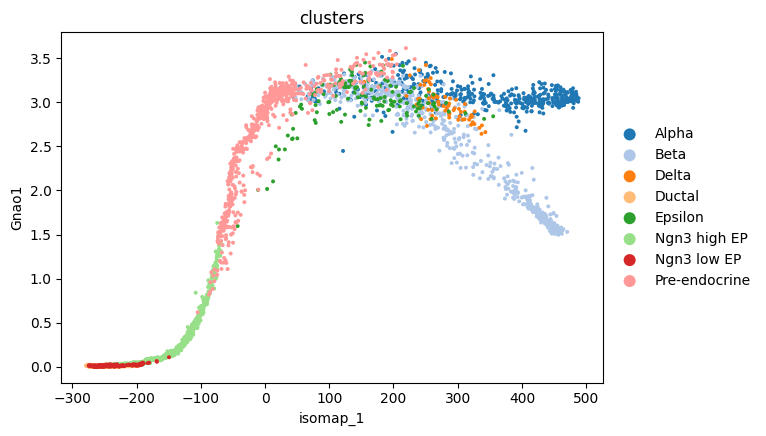

In [90]:
sc.pl.scatter(adata, x="isomap_1", y="Gnao1", layers="Mu", color="clusters")

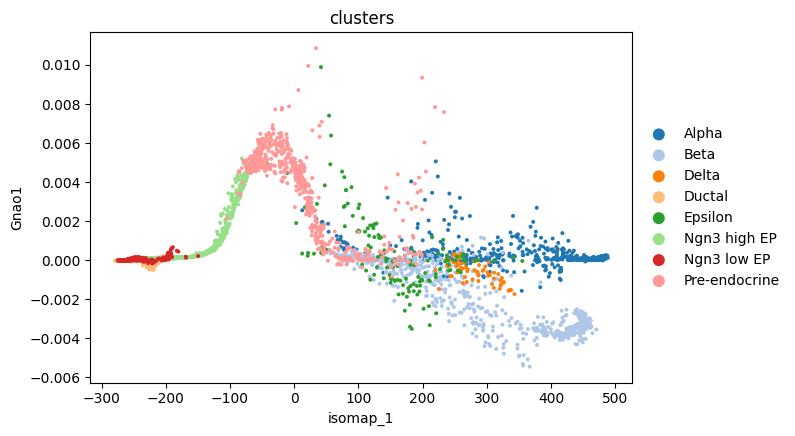

In [89]:
sc.pl.scatter(adata, x="isomap_1", y="Gnao1", layers="velocity_u", color="clusters")

IsADirectoryError: [Errno 21] Is a directory: '.'

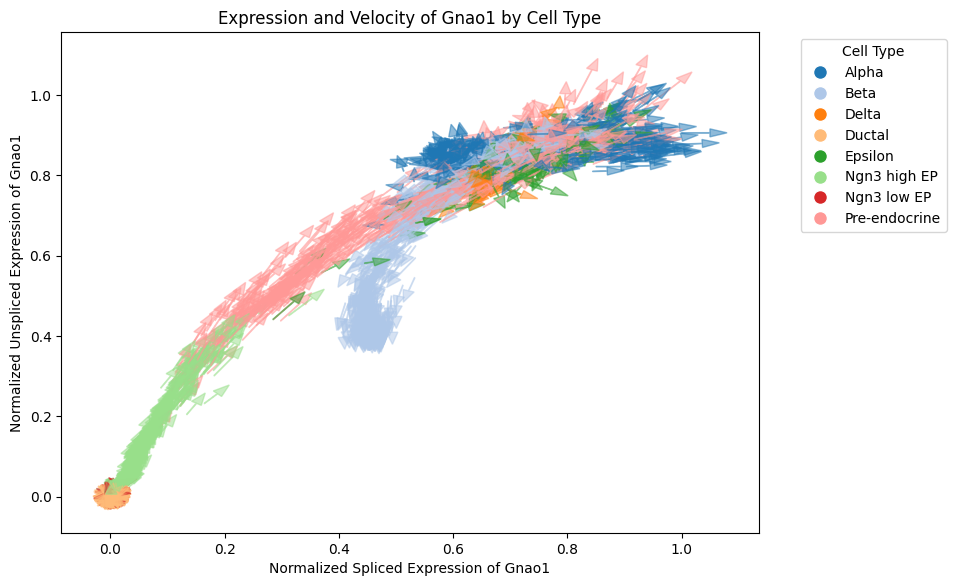

In [85]:
plot_phase_plane(adata, "Gnao1", dataset_name, 11, u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key)

In [ ]:
plot_phase_plane(adata, "Gnas", dataset_name, 11, u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key)

In [ ]:
#adata.write_h5ad("pancreas_goodresult.h5ad")